In [14]:
!conda activate asl

'conda' is not recognized as an internal or external command,
operable program or batch file.


# Exam DS807

## Preparation of data

### Labeling Data and converting images to array values

In [15]:
#import packages for labelling and converting imagery data
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from numpy import asarray
from sklearn import svm
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from keras import layers
from keras import models
from keras.applications.vgg16 import VGG16
from keras import optimizers
import tensorflow as tf
import matplotlib.pyplot as plt

In [16]:
##############
# Func for creating 1D image arrays

def load_image_function(path):
    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels
    for filename in os.listdir(path):
        container.append(filename) # add filename to container     
        CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
        color_mode="grayscale")                  
        CCDY_img = img_to_array(CCDY_img)
        images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays


In [17]:
################
# Func for creating df with classes and 3d img arrays

def load_img_data ():
    # Start: creatign classes ons string_digits
    # load string digits

    #os.chdir(path_string_digits)

    string_digits = pd.read_csv('DIDA_12000_String_Digit_Labels.csv', 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images as 1D tensors
    # Convert imagery to 1D arrays with tagged file names

    #os.chdir(path_images)
    image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1')

    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


In [18]:
#load data and shuffle them around
df = load_img_data()
df = df.sample(frac=1).reset_index(drop=True)
df

,index,string,CC,D,Y,img_value,filename
0,2349,1817,0,1,7,"[[[156.0], [157.0], [158.0], [158.0], [159.0],...",2349.jpg
1,6395,1821,0,2,1,"[[[80.0], [86.0], [81.0], [80.0], [85.0], [90....",6395.jpg
2,10992,1818,0,1,8,"[[[157.0], [162.0], [164.0], [160.0], [158.0],...",10992.jpg
3,1619,1824,0,2,4,"[[[140.0], [138.0], [137.0], [136.0], [138.0],...",1619.jpg
4,4629,1812,0,1,2,"[[[205.0], [204.0], [205.0], [200.0], [202.0],...",4629.jpg
...,...,...,...,...,...,...,...
11995,7912,1816,0,1,6,"[[[153.0], [144.0], [143.0], [144.0], [137.0],...",7912.jpg
11996,9799,1836,0,3,6,"[[[170.0], [171.0], [172.0], [173.0], [173.0],...",9799.jpg
11997,324,1804,0,0,4,"[[[141.0], [141.0], [142.0], [141.0], [139.0],...",324.jpg
11998,8563,1820,0,2,0,"[[[122.0], [128.0], [126.0], [128.0], [133.0],...",8563.jpg


### Defining fixed train, test and valdiation sets.

In [19]:
df = df.drop(columns=['index','string','filename'])

### Split train, val, test

#### Subsetting df

In [20]:
x_train = df.loc[0:7679]
x_val = df.loc[7680:9599]
x_test = df.loc[9600:11999]

#### Creating labels

In [21]:
#### training labels ###
Y_train = x_train['Y']
Y_train = Y_train.astype(np.uint8)
D_train = x_train['D']
D_train = D_train.astype(np.uint8)
CC_train = x_train['CC']
CC_train = CC_train.astype(np.uint8)

#### validation labels ###
Y_val = x_val['Y']
Y_val = Y_val.astype(np.uint8)
D_val = x_val['D']
D_val = D_val.astype(np.uint8)
CC_val = x_val['CC']
CC_val = CC_val.astype(np.uint8)

#### test labels ###
Y_test = x_test['Y']
Y_test = Y_test.astype(np.uint8)
D_test = x_test['D']
D_test = D_test.astype(np.uint8)
CC_test = x_test['CC']
CC_test = CC_test.astype(np.uint8)


#### Creating image values

In [22]:
# train
values = np.zeros(shape=(len(x_train),56,106,1))
i = 0
j = 0
while i < len(x_train):
    values[i] = x_train['img_value'][j]
    i += 1
    j+=1
x_train = values/255

# val
values = np.zeros(shape=(len(x_val),56,106,1))
i = 0
j = 7680
while i < len(x_val):
    values[i] = x_val['img_value'][j]
    i += 1
    j+=1
x_val = values/255

# test
values = np.zeros(shape=(len(x_test),56,106,1))
i = 0
j = 9600
while i < len(x_test):
    values[i] = x_test['img_value'][j]
    i += 1
    j+=1
x_test = values/255


## Question 1

### 1.2 Non-deeplearning CC-D-Y models

In [10]:
x_train_flat = x_train.reshape((len(x_train), -1))
x_val_flat = x_val.reshape((len(x_val), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

In [24]:
def score_calc(model,y_test,x_test):
    score = 0.0
    preds = model.predict(x_test)
    i = 0
    for row in y_test:
        if str(row) == str(preds[i][0]):
            score = score + (1/3)
        i= i + 1
    return score

#### SVM, modelCC

In [11]:
model = svm.SVC()
model.fit(x_train_flat, CC_train)
val_hat = model.predict(x_val_flat)
accuracy = accuracy_score(val_hat, CC_val)*100
accuracy

97.55208333333333

#### Catboost, modelD

In [16]:
results_catboost_D = []
n_iterations = [100,200,500]
lr = [0.01,0.1]
n_depth = [4,6]
loss_f = 'MultiClass'

for iters in n_iterations:
    for ls in lr:
        for depths in n_depth:
            model_D = CatBoostClassifier(iterations=iters,
                                        learning_rate=ls,
                                        depth=depths,
                                        loss_function=loss_f,
                                        task_type="GPU",
                                        devices='0:1')

            model_D.fit(x_train_flat, D_train, verbose=50)
            acc = model_D.score(x_val_flat,D_val)
            # the results from the different hyperparameters are then stored so we can get the best one
            results_catboost_D.append([acc,ls,iters, depths])
            print([acc,ls,iters, depths])
results_df_catboost_D = pd.DataFrame(results_catboost_D)
results_df_catboost_D.columns=['accuracy',"learning_rate","n_estimators", "depth"]
#prints the results from best to worst in regards to accuracy, listting the hyperparameters for the result
results_df_catboost_D = results_df_catboost_D.sort_values('accuracy', ascending=False)
results_df_catboost_D


0:	learn: 2.2887629	total: 136ms	remaining: 13.5s
50:	learn: 1.8662520	total: 4.91s	remaining: 4.72s
99:	learn: 1.6777988	total: 9.37s	remaining: 0us
[0.396875, 0.01, 100, 4]
0:	learn: 2.2886103	total: 330ms	remaining: 32.7s
50:	learn: 1.8515984	total: 16.2s	remaining: 15.6s
99:	learn: 1.6450200	total: 31.7s	remaining: 0us
[0.44114583333333335, 0.01, 100, 6]
0:	learn: 2.1705851	total: 115ms	remaining: 11.3s
50:	learn: 1.3272531	total: 4.69s	remaining: 4.51s
99:	learn: 1.1892576	total: 9.17s	remaining: 0us
[0.5171875, 0.1, 100, 4]
0:	learn: 2.1687604	total: 328ms	remaining: 32.5s
50:	learn: 1.2001364	total: 16.6s	remaining: 16s
99:	learn: 1.0085116	total: 32.4s	remaining: 0us
[0.5536458333333333, 0.1, 100, 6]
0:	learn: 2.2887634	total: 116ms	remaining: 23s
50:	learn: 1.8662523	total: 4.79s	remaining: 14s
100:	learn: 1.6750856	total: 9.27s	remaining: 9.08s
150:	learn: 1.5682842	total: 13.3s	remaining: 4.33s
199:	learn: 1.5017392	total: 17.6s	remaining: 0us
[0.4395833333333333, 0.01, 200,

,accuracy,learning_rate,n_estimators,depth
11,0.627604,0.10,500,6
10,0.593750,0.10,500,4
7,0.585417,0.10,200,6
3,0.553646,0.10,100,6
9,0.553646,0.01,500,6
6,0.549479,0.10,200,4
2,0.517188,0.10,100,4
8,0.505729,0.01,500,4
5,0.504167,0.01,200,6
1,0.441146,0.01,100,6


In [17]:
results_df_catboost_D.to_csv('Catboost_results_DECADE')

In [18]:
test_acc = model_D.score(x_test_flat,D_test)
test_acc

0.6420833333333333

In [25]:
test_Score = score_calc(model_D,D_test,x_test_flat)
test_Score

513.6666666666551

#### Catboost, modelY

In [19]:
results_cat_Y = []
n_iterations = [500]#,200,100]
lr = [0.1]#,0.01]
n_depth = [6]#,4]
loss_f = 'MultiClass'

for iters in n_iterations:
    for ls in lr:
        for depths in n_depth:
            model_Y = CatBoostClassifier(iterations=iters,
                                        learning_rate=ls,
                                        depth=depths,
                                        loss_function=loss_f,
                                        task_type="GPU",
                                        devices='0:1')

            model_Y.fit(x_train_flat, Y_train, verbose=50)
            acc = model_Y.score(x_val_flat,Y_val)
            # the results from the different hyperparameters are then stored so we can get the best one
            results_cat_Y.append([acc,ls,iters, depths])
results_df_cat_Y = pd.DataFrame(results_cat_Y)
results_df_cat_Y.columns=['accuracy',"learning_rate","n_estimators", "depth"]
#prints the results from best to worst in regards to accuracy, listting the hyperparameters for the result
results_df_cat_Y = results_df_cat_Y.sort_values('accuracy', ascending=False)
results_df_cat_Y

0:	learn: 2.3600619	total: 396ms	remaining: 3m 17s
50:	learn: 1.7120842	total: 18.4s	remaining: 2m 42s
100:	learn: 1.4128335	total: 36.3s	remaining: 2m 23s
150:	learn: 1.2094868	total: 53s	remaining: 2m 2s
200:	learn: 1.0706529	total: 1m 9s	remaining: 1m 43s
250:	learn: 0.9751101	total: 1m 24s	remaining: 1m 24s
300:	learn: 0.8843965	total: 1m 40s	remaining: 1m 6s
350:	learn: 0.8116300	total: 1m 55s	remaining: 49.2s
400:	learn: 0.7521682	total: 2m 10s	remaining: 32.3s
450:	learn: 0.7016064	total: 2m 25s	remaining: 15.9s
499:	learn: 0.6563481	total: 2m 40s	remaining: 0us


,accuracy,learning_rate,n_estimators,depth
0,0.547396,0.1,500,6


In [19]:
results_df_cat_Y.to_csv('Catboost_results_YEAR')

In [20]:
test_acc = model_Y.score(x_test_flat,Y_test)
test_acc

0.5541666666666667

In [26]:
test_Score = score_calc(model_Y,Y_test,x_test_flat)
test_Score

443.3333333333256

## Question 2

### 2.2.A Construct a CNN

### 2.2.B Regularization

### 2.2.C Augmentation

### 2.2.D Transfer learning

#### CC model

In [23]:
x_train_transfer = tf.image.grayscale_to_rgb(tf.constant(x_train))
x_test_transfer = tf.image.grayscale_to_rgb(tf.constant(x_test))
x_val_transfer = tf.image.grayscale_to_rgb(tf.constant(x_val))

In [29]:

transfer_model_CC = VGG16(include_top=False, input_shape=(56, 106, 3))
# mark loaded layers as not trainable
for layer in transfer_model_CC.layers:
	layer.trainable = False
# add new classifier layers
flat1 = layers.Flatten()(transfer_model_CC.layers[-1].output)
class1 = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
drop1 = layers.Dropout(0.2)(class1)
output = layers.Dense(1, activation='sigmoid')(drop1)
# define new model
transfer_model_CC = models.Model(inputs=transfer_model_CC.inputs, outputs=output)

transfer_model_CC.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0008), loss='binary_crossentropy', metrics=['accuracy'])
transfer_model_CC.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 56, 106, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 106, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 106, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 53, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 53, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 53, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 26, 128)       0   

C:\Users\oeste\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [30]:
transfer_history_CC = transfer_model_CC.fit(x_train_transfer,CC_train, 
                                            steps_per_epoch=len(x_train_transfer), 
                                            epochs=50,
                                            validation_data=(x_val_transfer,CC_val), 
                                            validation_steps=len(x_val_transfer), 
                                            callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/50
7680/7680 [==============================] - 60s 8ms/step - loss: 0.0836 - accuracy: 0.9790 - val_loss: 0.0824 - val_accuracy: 0.9755
Epoch 2/50
7680/7680 [==============================] - 66s 9ms/step - loss: 0.0510 - accuracy: 0.9863 - val_loss: 0.0539 - val_accuracy: 0.9859
Epoch 3/50
7680/7680 [==============================] - 63s 8ms/step - loss: 0.0438 - accuracy: 0.9880 - val_loss: 0.0564 - val_accuracy: 0.9865
Epoch 4/50
7680/7680 [==============================] - 66s 9ms/step - loss: 0.0386 - accuracy: 0.9896 - val_loss: 0.0529 - val_accuracy: 0.9859
Epoch 5/50
7680/7680 [==============================] - 67s 9ms/step - loss: 0.0338 - accuracy: 0.9902 - val_loss: 0.0545 - val_accuracy: 0.9870
Epoch 6/50
7680/7680 [==============================] - 68s 9ms/step - loss: 0.0338 - accuracy: 0.9901 - val_loss: 0.0650 - val_accuracy: 0.9859
Epoch 7/50
7680/7680 [==============================] - 67s 9ms/step - loss: 0.0306 - accuracy: 0.9919 - val_loss: 0.0649 - val_ac

In [31]:
transfer_model_CC.evaluate(x_test_transfer,CC_test)

75/75 [==============================] - 2s 24ms/step - loss: 0.0615 - accuracy: 0.9833


[0.06154831498861313, 0.9833333492279053]

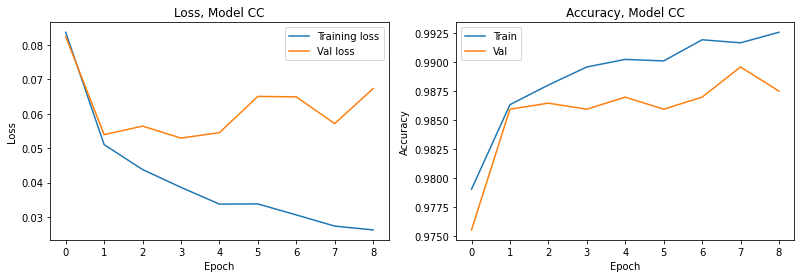

In [32]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(transfer_history_CC.history['loss'], label='Training loss')
ax.plot(transfer_history_CC.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(transfer_history_CC.history['accuracy'], label='Train')
ax.plot(transfer_history_CC.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model CC')

plt.show()

#### Y Model

In [33]:
transfer_model_Y = VGG16(include_top=False, input_shape=(56, 106, 3))
# mark loaded layers as not trainable
for layer in transfer_model_Y.layers:
	layer.trainable = False
# add new classifier layers
flat1 = layers.Flatten()(transfer_model_Y.layers[-1].output)
class1 = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
drop1 = layers.Dropout(0.2)(class1)
output = layers.Dense(11, activation='softmax')(drop1)
# define new model
transfer_model_Y = models.Model(inputs=transfer_model_Y.inputs, outputs=output)

transfer_model_Y.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0008), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model_Y.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 56, 106, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 106, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 106, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 53, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 53, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 53, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 26, 128)       0   

In [34]:
transfer_history_Y = transfer_model_Y.fit(x_train_transfer,Y_train, 
                                            steps_per_epoch=len(x_train_transfer), 
                                            epochs=50,
                                            validation_data=(x_val_transfer,Y_val), 
                                            validation_steps=len(x_val_transfer), 
                                            callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/50
7680/7680 [==============================] - 65s 8ms/step - loss: 2.0187 - accuracy: 0.2758 - val_loss: 1.7129 - val_accuracy: 0.3974
Epoch 2/50
7680/7680 [==============================] - 65s 8ms/step - loss: 1.6449 - accuracy: 0.4089 - val_loss: 1.4107 - val_accuracy: 0.5297
Epoch 3/50
7680/7680 [==============================] - 62s 8ms/step - loss: 1.4826 - accuracy: 0.4723 - val_loss: 1.3764 - val_accuracy: 0.5281
Epoch 4/50
7680/7680 [==============================] - 64s 8ms/step - loss: 1.4019 - accuracy: 0.5039 - val_loss: 1.3207 - val_accuracy: 0.5385
Epoch 5/50
7680/7680 [==============================] - 65s 8ms/step - loss: 1.3485 - accuracy: 0.5158 - val_loss: 1.2212 - val_accuracy: 0.5932
Epoch 6/50
7680/7680 [==============================] - 66s 9ms/step - loss: 1.2865 - accuracy: 0.5431 - val_loss: 1.2060 - val_accuracy: 0.5849
Epoch 7/50
7680/7680 [==============================] - 63s 8ms/step - loss: 1.2549 - accuracy: 0.5531 - val_loss: 1.1837 - val_ac

In [35]:
transfer_model_Y.evaluate(x_test_transfer,Y_test)

75/75 [==============================] - 2s 23ms/step - loss: 1.0634 - accuracy: 0.6662


[1.0634398460388184, 0.6662499904632568]

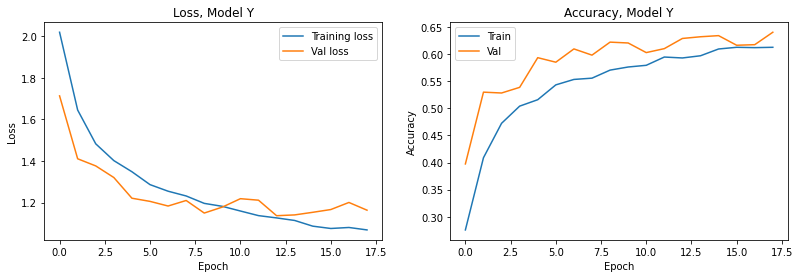

In [36]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(transfer_history_Y.history['loss'], label='Training loss')
ax.plot(transfer_history_Y.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(transfer_history_Y.history['accuracy'], label='Train')
ax.plot(transfer_history_Y.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model Y')

plt.show()

#### D Model


In [12]:
transfer_model_D = VGG16(include_top=False, input_shape=(56, 106, 3))
# mark loaded layers as not trainable
for layer in transfer_model_D.layers:
	layer.trainable = False
# add new classifier layers
flat1 = layers.Flatten()(transfer_model_D.layers[-1].output)
class1 = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
drop1 = layers.Dropout(0.2)(class1)
output = layers.Dense(11, activation='softmax')(drop1)
# define new model
transfer_model_D = models.Model(inputs=transfer_model_D.inputs, outputs=output)

transfer_model_D.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0008), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model_D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56, 106, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 106, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 106, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 53, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 53, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 53, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 26, 128)       0     

C:\Users\oeste\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
transfer_history_D = transfer_model_D.fit(x_train_transfer,D_train, 
                                            steps_per_epoch=len(x_train_transfer), 
                                            epochs=50,
                                            validation_data=(x_val_transfer,D_val), 
                                            validation_steps=len(x_val_transfer), 
                                            callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/50
7680/7680 [==============================] - 77s 10ms/step - loss: 1.4446 - accuracy: 0.4020 - val_loss: 1.2281 - val_accuracy: 0.5052
Epoch 2/50
7680/7680 [==============================] - 75s 10ms/step - loss: 1.2405 - accuracy: 0.4954 - val_loss: 1.1389 - val_accuracy: 0.5458
Epoch 3/50
7680/7680 [==============================] - 75s 10ms/step - loss: 1.1703 - accuracy: 0.5232 - val_loss: 1.0896 - val_accuracy: 0.5740
Epoch 4/50
7680/7680 [==============================] - 75s 10ms/step - loss: 1.1466 - accuracy: 0.5335 - val_loss: 1.1466 - val_accuracy: 0.5552
Epoch 5/50
7680/7680 [==============================] - 75s 10ms/step - loss: 1.1179 - accuracy: 0.5531 - val_loss: 1.0454 - val_accuracy: 0.5859
Epoch 6/50
7680/7680 [==============================] - 74s 10ms/step - loss: 1.1247 - accuracy: 0.5454 - val_loss: 1.0916 - val_accuracy: 0.5813
Epoch 7/50
7680/7680 [==============================] - 71s 9ms/step - loss: 1.1056 - accuracy: 0.5535 - val_loss: 1.0977 - 

In [25]:
transfer_model_D.evaluate(x_test_transfer,D_test)

75/75 [==============================] - 14s 134ms/step - loss: 1.0684 - accuracy: 0.6300


[1.0683971643447876, 0.6299999952316284]

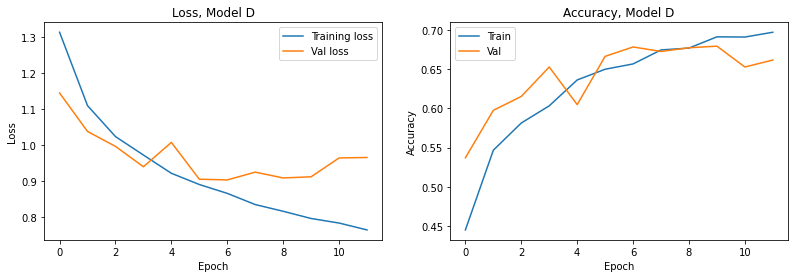

In [40]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(transfer_history_D.history['loss'], label='Training loss')
ax.plot(transfer_history_D.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(transfer_history_D.history['accuracy'], label='Train')
ax.plot(transfer_history_D.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model D')

plt.show()

## 2.3 Prefered CNN model

## Question 3

### 3.1 Visualization of activation maps

### 3.2 Investigating model performance